# Create media designs using Latin Hypercube for LCMS flaviolin experiment

This notebook generates a set of media designs using Latin Hypercube sampling. We use ART's capability to provide this kind of designs for media components for which to get phenotypic data. We will use two types of assays for this experiment - absorbance at 340nm and LCMS measurements.  


We include a design that is very close to the standard media (up to 5% variation for each component), as a control for every cycle.

Tested using **ART 3.9.4** kernel on jprime.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `Putida_media_bounds.csv`
- `standard_recipe_concentrations.csv`

**File generated by running this notebook**
- `recommendations_initial.csv`

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [1]:
import sys
sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
sys.path.append('../')
 
import matplotlib.pyplot as plt

from art.core import * 
from core import designs_pairwise


## User parameters

### Defining media components and the number of instances (designs) to be created

In [2]:
CYCLE = 6

user_params = {
    'bounds_file': f'../data/flaviolin/Putida_media_bounds.csv',
    'output_file_path': f'../data/flaviolin/DBTL{CYCLE}', # Folder for output files,
    'standard_media_file': '../data/flaviolin/standard_recipe_concentrations.csv',
}

Specify which components to explore:

In [3]:
user_params['components'] = [
    'H3BO3',
    'K2SO4',
    'K2HPO4',
    'FeSO4',
    'NH4Cl',
    'MgCl2',
    'NaCl',
    '(NH4)6Mo7O24',
    'CoCl2',
    'CuSO4',
    'MnSO4',
    'ZnSO4'
]

Here we specify how many instances (designs) we want to create and how many replicates (change as desired). In this case we run two DBTL cycles with initial designs, 12 instances with 4 replicates for each, out of which one design is reserved for the control.

In [4]:
user_params['n_instances'] = 15
user_params['n_replicates'] = 3 

In [5]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

In [6]:
df_stand

,Concentration[mM],Solubility[mM]
Component,,
MOPS,40.00000,2389.37
Tricine,4.00000,500.08
H3BO3,0.00400,700.00
Glucose,20.00000,5045.63
K2SO4,0.29000,636.98
K2HPO4,1.32000,8564.84
FeSO4,0.01000,1645.73
NH4Cl,9.52000,6543.28
MgCl2,0.52000,569.27


### Generate the control media 

Control media will be uniformly drawn from the interval 90% to 110% around the standard recipe.

In [7]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration[mM]']
    df_control.at[0, component] = stand_conc*np.random.uniform(lb, ub)


In [8]:
df_control

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
0,0.003968,0.278836,1.196387,0.010759,10.408408,0.475231,51.20097,0.000028,0.000316,0.000091,0.000777,0.000103


### Generate random media

Define a dictionary that contains the settings that ART will use to find the recommended designs:

In [9]:
art_params = {
    'input_vars': user_params['components'],  # input variables, i.e. features
    'bounds_file': user_params['bounds_file'],  # file with bounds
    'num_recommendations': user_params['n_instances'],   
    'initial_cycle': True,                                    # Set this to True for initial designs recommendations
    'seed': 10,                                               # seed for number random generator
    'output_directory': user_params['output_file_path']  # directory to store this output
}


With the configuration stored in `art_params`, we now run ART:

In [10]:
art = RecommendationEngine(**art_params)
df = art.recommendations.copy()
df.tail()

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
10,0.011667,2.882740,0.995188,0.090655,10.324943,1.933593,189.206250,0.000157,0.000048,0.000507,0.002133,0.000588
11,0.021833,0.405193,0.424550,0.045675,7.721296,3.019698,136.129853,0.000142,0.002977,0.000726,0.006938,0.000415
12,0.007477,1.365148,3.268669,0.097711,10.965631,0.771413,391.274625,0.000066,0.001611,0.000809,0.006266,0.000899
13,0.034219,0.487692,5.964381,0.078645,9.187989,2.424902,103.608502,0.000248,0.001288,0.000352,0.000772,0.000867
14,0.002513,0.691736,2.092997,0.061301,9.694639,1.242139,147.653638,0.000061,0.000376,0.000416,0.003509,0.000269


In [11]:
df_target = df.copy()
df_target = df_target.append(df_control).reset_index(drop=True)
df_target

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
0,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.00095,0.004621,0.000744
1,0.008628,0.896852,5.044414,0.017022,13.269195,2.52172,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
2,0.01668,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363
3,0.039421,2.139989,6.48219,0.004907,8.404625,1.63091,409.900003,0.000029,0.000997,0.000322,0.000492,0.0003
4,0.003822,2.110887,4.828971,0.054005,12.426865,3.494197,309.231334,0.000193,0.001809,0.00002,0.004225,0.00049
5,0.019247,0.063172,5.616681,0.071373,8.774074,0.114856,486.966008,0.000276,0.002404,0.000233,0.00758,0.000716
6,0.014314,1.389174,3.018874,0.03269,11.53211,3.145739,66.174686,0.000219,0.00109,0.000193,0.007039,0.000647
7,0.03157,1.171567,2.755917,0.039552,12.915469,0.694204,347.206468,0.000167,0.002186,0.000782,0.003175,0.000109
8,0.03717,2.57281,1.415232,0.026265,14.070721,4.071614,286.626122,0.000286,0.000589,0.000105,0.00532,0.000975
9,0.027296,1.86347,1.870718,0.051378,12.142509,4.286369,441.442899,0.000005,0.002629,0.000664,0.005428,0.000175


### Checking the distribution of initial designs

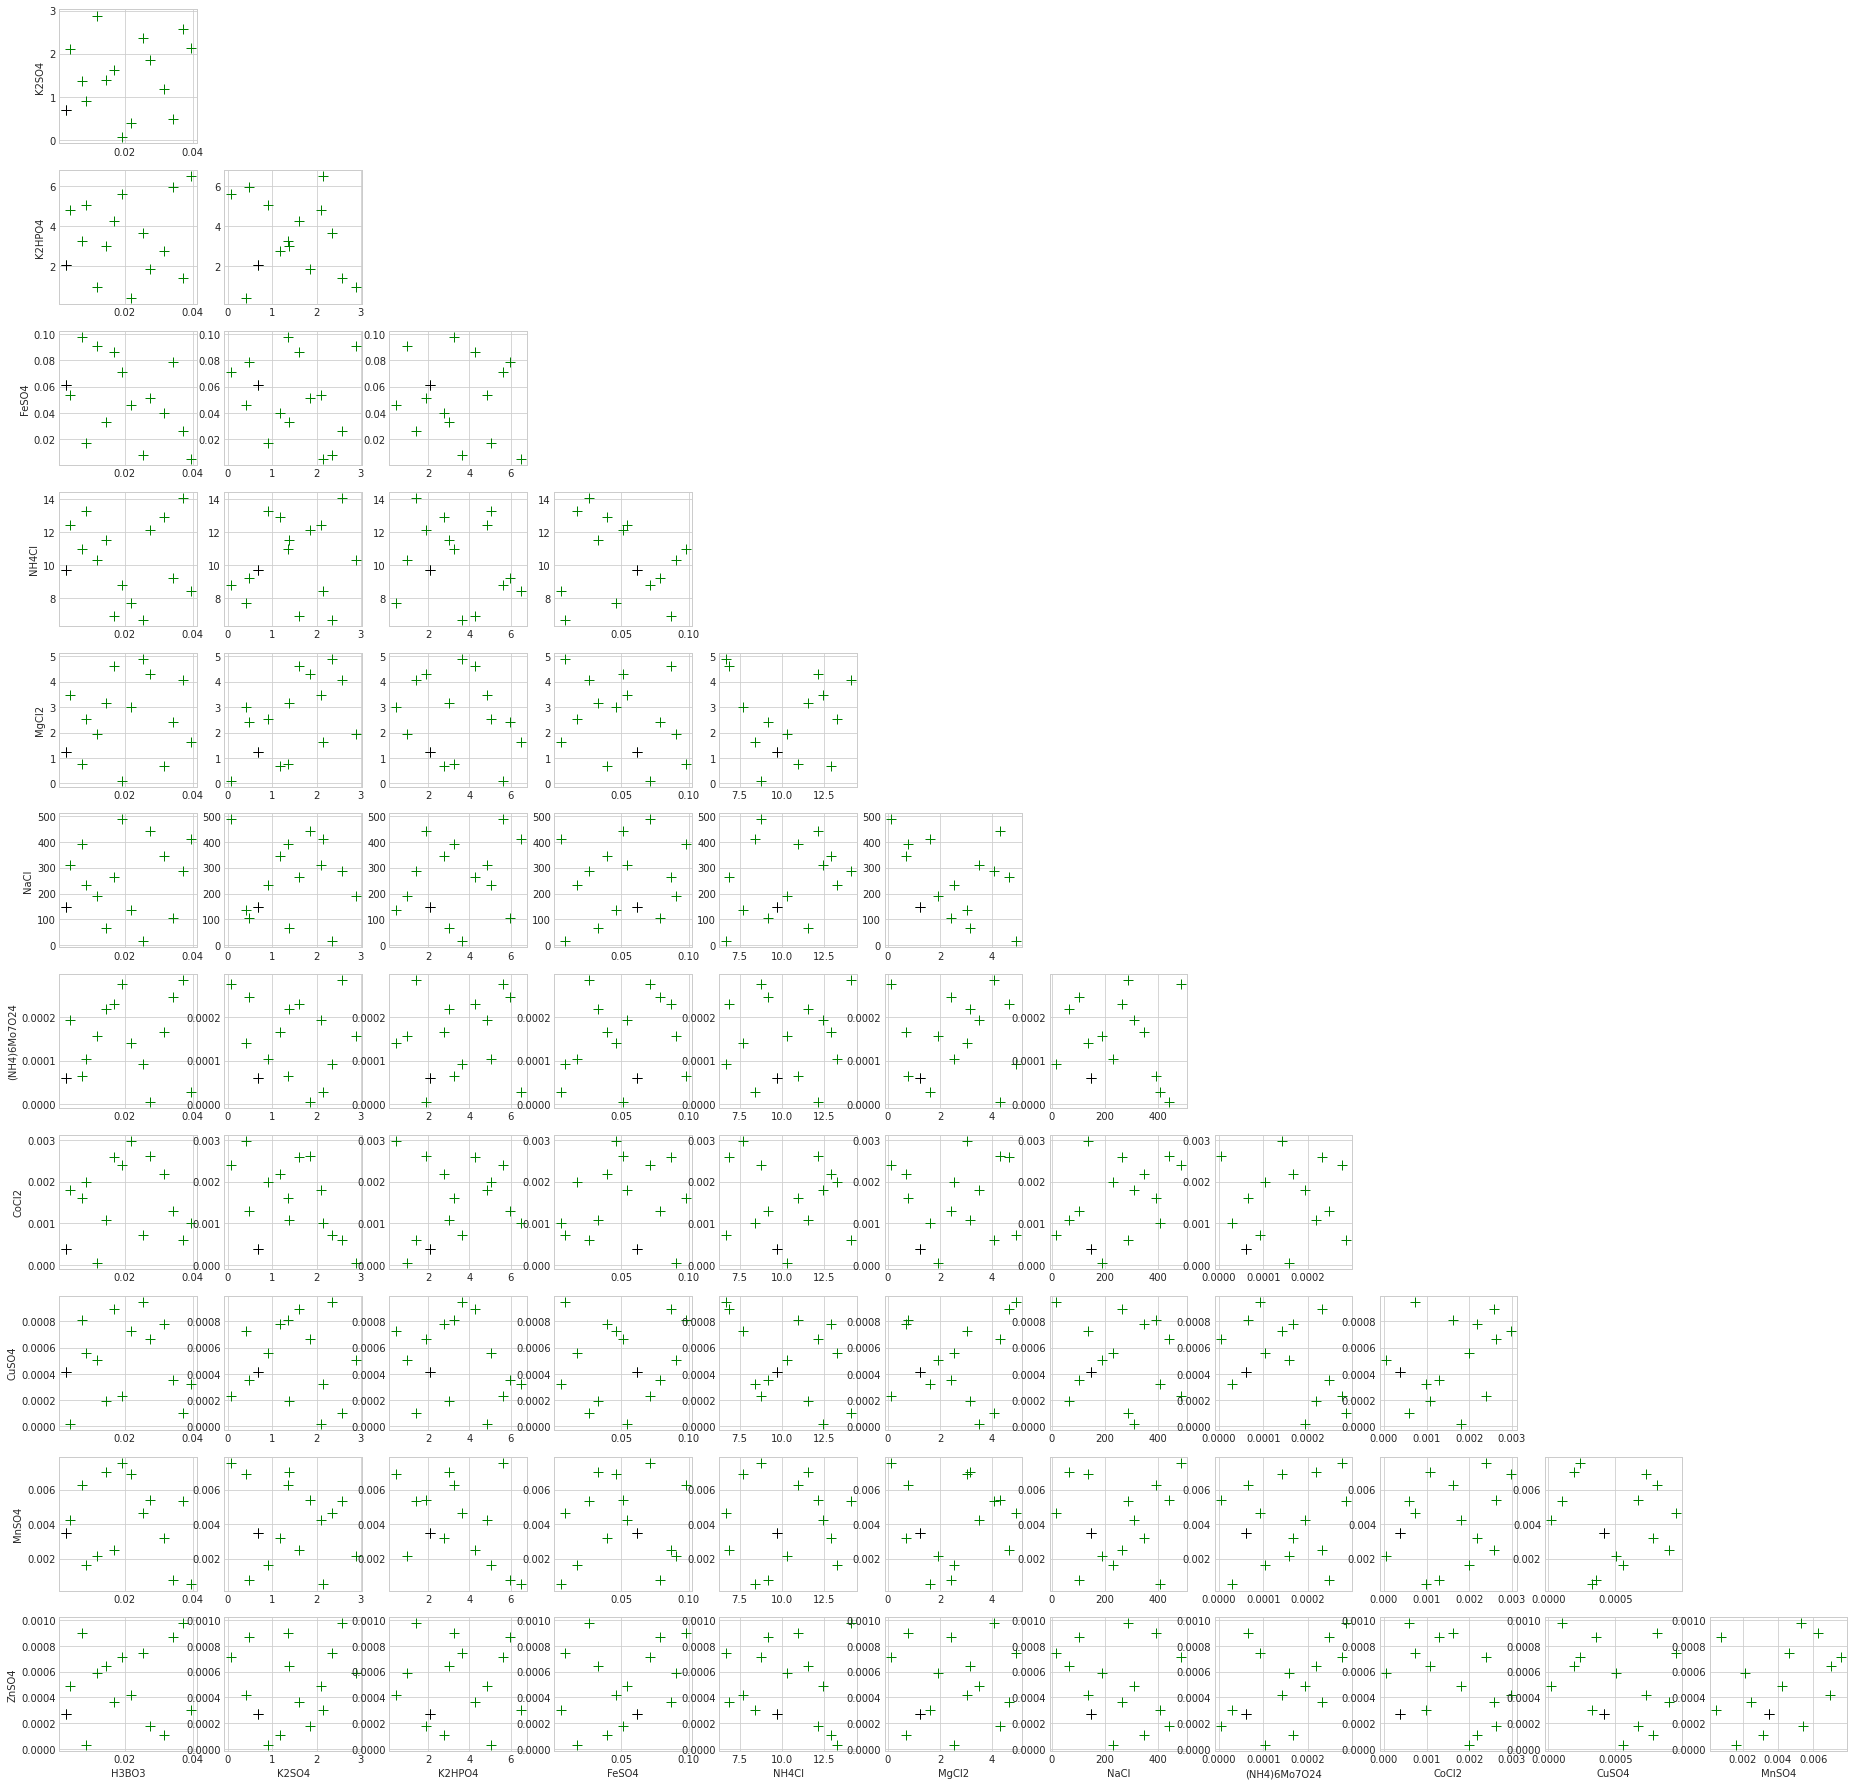

In [12]:
designs_pairwise(art, df, user_params, initial=True)

## Saving the generated designs

Include all replicates: 

In [13]:
df_target = df_target.loc[df_target.index.repeat(user_params['n_replicates'])]


Rename index to well names:

In [14]:
well_rows = 'ABCDEF'
well_columns = '12345678'

In [15]:
well_names = [f'{row}{column}' for column in well_columns for row in well_rows]

df_target['Well'] = well_names
df_target = df_target.set_index(['Well'])
df_target

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
Well,,,,,,,,,,,,
A1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.00095,0.004621,0.000744
B1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.00095,0.004621,0.000744
C1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.00095,0.004621,0.000744
D1,0.008628,0.896852,5.044414,0.017022,13.269195,2.52172,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
E1,0.008628,0.896852,5.044414,0.017022,13.269195,2.52172,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
F1,0.008628,0.896852,5.044414,0.017022,13.269195,2.52172,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
A2,0.01668,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363
B2,0.01668,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363
C2,0.01668,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363


In [16]:
file = f"{user_params['output_file_path']}/target_concentrations.csv"
df_target.to_csv(file)